# 01 — MNIST Digits Classification 🔢🧠

<p align="left">
  <img alt="MLP" src="https://img.shields.io/badge/MLP-Neural%20Network-ff69b4">
  <img alt="Backprop" src="https://img.shields.io/badge/FromScratch-Backprop-orange">
  <img alt="Status" src="https://img.shields.io/badge/Notebook-Modeling-1e90ff">
</p>

> **Purpose**: Build a Multi-Layer Perceptron (MLP) **from scratch (NumPy only)** to classify MNIST digits, implement backprop manually, and present explainable evaluation.  
> **Author**: <span style="color:#FF6B6B"><b>Noëlla Buti</b></span>

---

### 🛠️ Workflow
1. 📥 Load & normalize MNIST CSV data ([0.01, 1.0])  
2. 🔢 One-hot encode labels  
3. ⚙️ Initialize weights (Xavier) & biases  
4. ➡️ Forward pass: Sigmoid hidden layer(s), Softmax output  
5. 🔄 Backpropagation: Cross-entropy, updates (SGD + momentum + L2)  
6. 📈 Train (LR decay, optional early stopping)  
7. ✅ Evaluate test accuracy & confusion matrix  
8. 🔍 Industry pack: per-class metrics, most-confident mistakes, calibration (ECE), saliency, model card

<details>
  <summary><b>📁 Artifacts (click to expand)</b></summary>

- Confusion matrix:  
  <code>/content/drive/MyDrive/reports/confusion_matrix.png</code>  
- Saved weights:  
  <code>/content/drive/MyDrive/artifacts/mlp_weights_biases_1hidden.npz</code>  
- Model card & run config:  
  <code>/content/drive/MyDrive/reports/model_card.json</code>  
  <code>/content/drive/MyDrive/reports/config.json</code>  
- Notebook path:  
  <code>/content/drive/MyDrive/</code>
</details>

---

### 🚦 Results Snapshot (Latest)
- **Hidden layer(s):** 1 × 256 logistic  
- **Accuracy (test)** = **97.64%**  
- **Correct classifications**: **9,764**  
- **Incorrect classifications**: **236**

---

>💡 This is a vanilla MLP (sigmoid → softmax) trained with SGD + momentum and LR decay. The notebook includes confusion matrix, per-class report, calibration/ECE, saliency and reproducibility artifacts (saved weights + model card).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [2]:
import os, json, time, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Output folders (reports, artifacts)
Path("reports").mkdir(parents=True, exist_ok=True)
Path("artifacts").mkdir(parents=True, exist_ok=True)

# Reproducibility
RNG = np.random.default_rng(42)
np.set_printoptions(precision=4, suppress=True)

## 1. Load MNIST CSVs

In [3]:
# File paths
train_x_path = "data/raw/training60000.csv"
train_y_path = "data/raw/training60000_labels.csv"
test_x_path  = "data/raw/testing10000.csv"
test_y_path  = "data/raw/testing10000_labels.csv"

# Load CSVs
X_train = pd.read_csv(train_x_path, header=None).values.astype(np.float32)
y_train = pd.read_csv(train_y_path, header=None).values.reshape(-1).astype(int)
X_test  = pd.read_csv(test_x_path,  header=None).values.astype(np.float32)
y_test  = pd.read_csv(test_y_path,  header=None).values.reshape(-1).astype(int)

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Verify/ensure range normalization to [0.01, 1.0] (avoid double-normalizing)
def needs_range_norm(X):
    xmin, xmax = X.min(), X.max()
    return not (xmin >= 0.01 - 1e-6 and xmax <= 1.0 + 1e-6)

if needs_range_norm(X_train) or needs_range_norm(X_test):
    low, high = 0.01, 1.0
    X_train = (X_train / 255.0) * (high - low) + low
    X_test  = (X_test  / 255.0) * (high - low) + low
    print("Applied range normalization to [0.01, 1.0]")
else:
    print("CSV data already in [0.01, 1.0] — no extra normalization applied.")

Shapes: (60000, 784) (60000,) (10000, 784) (10000,)
CSV data already in [0.01, 1.0] — no extra normalization applied.


## 2. Preprocessing Data (Labels → One-Hot, Set Sizes)

In [4]:
# One-hot encoding for labels
def one_hot(y, num_classes=10):
    Y = np.zeros((y.shape[0], num_classes), dtype=np.float32)
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

Y_train = one_hot(y_train, 10)
Y_test  = one_hot(y_test, 10)

# Model dimensions
input_size  = X_train.shape[1]  # 784 (28*28 pixels)
output_size = 10                # digits 0–9

print("One-hot Y_train shape:", Y_train.shape)
print("One-hot Y_test shape:", Y_test.shape)
print("Input size:", input_size, "| Output size:", output_size)

One-hot Y_train shape: (60000, 10)
One-hot Y_test shape: (10000, 10)
Input size: 784 | Output size: 10


## 3. Activation Functions and Loss

In [5]:
def sigmoid(z):
    """Logistic activation (hidden layers)."""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivative(a):
    """Derivative using activation a = sigmoid(z)."""
    return a * (1.0 - a)

def softmax(z):
    """Softmax activation (output layer)."""
    z = z - np.max(z, axis=1, keepdims=True)  # numerical stability
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true, weights=None, lam=0.0):
    """Cross-entropy loss with optional L2 regularization."""
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1.0 - eps)
    ce = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    if lam > 0 and weights is not None:
        ce += 0.5 * lam * sum(np.sum(W*W) for W in weights)
    return ce

## 4. Initialize Parameters (Xavier) + 1/2-Layer Toggle

In [6]:
def xavier_init(fan_in, fan_out, rng=RNG):
    """Glorot/Xavier uniform init, good for sigmoid nets."""
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return rng.uniform(-limit, limit, size=(fan_in, fan_out)).astype(np.float32)

# Toggle: use one hidden layer or two
USE_TWO_HIDDEN = False   # set to True later if you want a second hidden layer

# Hidden sizes (you can change later; start simple)
hidden_size_1 = 128
hidden_size_2 = 64   # used only when USE_TWO_HIDDEN=True

# Initialize weights & biases
if not USE_TWO_HIDDEN:
    W1 = xavier_init(input_size,  hidden_size_1); b1 = np.zeros((1, hidden_size_1), dtype=np.float32)
    W2 = xavier_init(hidden_size_1, output_size); b2 = np.zeros((1, output_size),    dtype=np.float32)
    # ensure names exist even in 1-hidden mode (prevents later toggle errors)
    W3, b3 = None, None
else:
    W1 = xavier_init(input_size,  hidden_size_1); b1 = np.zeros((1, hidden_size_1), dtype=np.float32)
    W2 = xavier_init(hidden_size_1, hidden_size_2); b2 = np.zeros((1, hidden_size_2), dtype=np.float32)
    W3 = xavier_init(hidden_size_2, output_size); b3 = np.zeros((1, output_size),    dtype=np.float32)

print("Initialized:",
      f"W1 {W1.shape}, b1 {b1.shape}, "
      f"W2 {W2.shape}, b2 {b2.shape}, "
      f"W3 {'None' if W3 is None else W3.shape}, b3 {'None' if b3 is None else b3.shape}")

Initialized: W1 (784, 128), b1 (1, 128), W2 (128, 10), b2 (1, 10), W3 None, b3 None


## 5. Forward Pass (1 or 2 Hidden Layers)

In [7]:
def forward_one_hidden(X):
    """
    Forward for 1-hidden-layer MLP:
      X -> (W1,b1) -> a1 = sigmoid -> (W2,b2) -> a2 = softmax
    Returns:
      probs (a2), cache (tensors needed for backprop)
    """
    z1 = X @ W1 + b1
    a1 = sigmoid(z1)
    z2 = a1 @ W2 + b2
    a2 = softmax(z2)
    cache = (X, a1, a2)
    return a2, cache

def forward_two_hidden(X):
    """
    Forward for 2-hidden-layer MLP:
      X -> (W1,b1) -> a1 = sigmoid -> (W2,b2) -> a2 = sigmoid -> (W3,b3) -> a3 = softmax
    Returns:
      probs (a3), cache (tensors needed for backprop)
    """
    z1 = X @ W1 + b1
    a1 = sigmoid(z1)
    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2)
    z3 = a2 @ W3 + b3
    a3 = softmax(z3)
    cache = (X, a1, a2, a3)
    return a3, cache

## 6. Backpropagation (with L2 Option)

In [8]:
def backprop_one_hidden(Xb, Yb, cache, lam=1e-4):
    """
    Backprop for 1-hidden-layer MLP.
    Inputs:
      Xb, Yb  : mini-batch inputs and one-hot targets
      cache   : (X, a1, a2) from forward_one_hidden
      lam     : L2 regularization strength
    Returns:
      dW1, db1, dW2, db2
    """
    X, a1, a2 = cache

    # Output layer delta (softmax + cross-entropy)
    delta2 = a2 - Yb  # (B, 10)

    # Gradients for W2, b2 (with L2 on weights)
    dW2 = (a1.T @ delta2) / Xb.shape[0] + lam * W2
    db2 = np.mean(delta2, axis=0, keepdims=True)

    # Hidden layer delta
    delta1 = (delta2 @ W2.T) * sigmoid_derivative(a1)  # (B, H1)

    # Gradients for W1, b1 (with L2 on weights)
    dW1 = (X.T @ delta1) / Xb.shape[0] + lam * W1
    db1 = np.mean(delta1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2


def backprop_two_hidden(Xb, Yb, cache, lam=1e-4):
    """
    Backprop for 2-hidden-layer MLP.
    Inputs:
      Xb, Yb  : mini-batch inputs and one-hot targets
      cache   : (X, a1, a2, a3) from forward_two_hidden
      lam     : L2 regularization strength
    Returns:
      dW1, db1, dW2, db2, dW3, db3
    """
    X, a1, a2, a3 = cache

    # Output layer delta
    delta3 = a3 - Yb  # (B, 10)

    # Gradients for W3, b3
    dW3 = (a2.T @ delta3) / Xb.shape[0] + lam * W3
    db3 = np.mean(delta3, axis=0, keepdims=True)

    # Second hidden delta
    delta2 = (delta3 @ W3.T) * sigmoid_derivative(a2)  # (B, H2)

    # Gradients for W2, b2
    dW2 = (a1.T @ delta2) / Xb.shape[0] + lam * W2
    db2 = np.mean(delta2, axis=0, keepdims=True)

    # First hidden delta
    delta1 = (delta2 @ W2.T) * sigmoid_derivative(a1)  # (B, H1)

    # Gradients for W1, b1
    dW1 = (X.T @ delta1) / Xb.shape[0] + lam * W1
    db1 = np.mean(delta1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

## 7. Training (Mini-Batch SGD, Momentum, and LR Decay)

In [9]:
def iterate_minibatches(X, Y, batch_size, rng=RNG):
    """Yield shuffled mini-batches."""
    n = X.shape[0]
    idx = rng.permutation(n)
    for start in range(0, n, batch_size):
        sl = idx[start:start+batch_size]
        yield X[sl], Y[sl]

def train(
    X, Y, X_val=None, Y_val=None,
    epochs=15, batch_size=128,
    lr0=0.1, momentum=0.9, lam=1e-4,
    lr_decay=0.95, early_stop=False, patience=5
):
    """
    Train the MLP with SGD+momentum and optional early stopping.
    Uses global weight matrices W1,b1,(W2,b2[,W3,b3]).
    """
    # bind all possible globals once
    global W1, b1, W2, b2, W3, b3

    # velocity buffers (same shapes as weights/biases)
    vW1 = np.zeros_like(W1); vB1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2); vB2 = np.zeros_like(b2)
    if USE_TWO_HIDDEN:
        if W3 is None or b3 is None:
            raise RuntimeError("USE_TWO_HIDDEN=True but W3/b3 not initialized.")
        vW3 = np.zeros_like(W3); vB3 = np.zeros_like(b3)

    history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}

    # early stopping state
    best_val = np.inf
    patience_left = patience
    best_snapshot = None

    for epoch in range(epochs):
        lr = lr0 * (lr_decay ** epoch)

        for Xb, Yb in iterate_minibatches(X, Y, batch_size):
            # forward
            if not USE_TWO_HIDDEN:
                probs, cache = forward_one_hidden(Xb)
                dW1, db1_g, dW2, db2_g = backprop_one_hidden(Xb, Yb, cache, lam)

                # momentum updates
                vW1 = momentum * vW1 + lr * dW1;   W1 -= vW1
                vB1 = momentum * vB1 + lr * db1_g; b1 -= vB1
                vW2 = momentum * vW2 + lr * dW2;   W2 -= vW2
                vB2 = momentum * vB2 + lr * db2_g; b2 -= vB2
            else:
                probs, cache = forward_two_hidden(Xb)
                dW1, db1_g, dW2, db2_g, dW3, db3_g = backprop_two_hidden(Xb, Yb, cache, lam)

                vW1 = momentum * vW1 + lr * dW1;   W1 -= vW1
                vB1 = momentum * vB1 + lr * db1_g; b1 -= vB1
                vW2 = momentum * vW2 + lr * dW2;   W2 -= vW2
                vB2 = momentum * vB2 + lr * db2_g; b2 -= vB2
                vW3 = momentum * vW3 + lr * dW3;   W3 -= vW3
                vB3 = momentum * vB3 + lr * db3_g; b3 -= vB3

        # end-of-epoch metrics on train
        if not USE_TWO_HIDDEN:
            train_probs, _ = forward_one_hidden(X)
            weights = [W1, W2]
        else:
            train_probs, _ = forward_two_hidden(X)
            weights = [W1, W2, W3]

        train_loss = cross_entropy_loss(train_probs, Y, weights, lam)
        train_acc  = (np.argmax(train_probs, 1) == np.argmax(Y, 1)).mean()

        # optional validation metrics
        if X_val is not None and Y_val is not None:
            if not USE_TWO_HIDDEN:
                val_probs, _ = forward_one_hidden(X_val)
            else:
                val_probs, _ = forward_two_hidden(X_val)
            val_loss = cross_entropy_loss(val_probs, Y_val, weights, lam)
            val_acc  = (np.argmax(val_probs, 1) == np.argmax(Y_val, 1)).mean()
        else:
            val_loss, val_acc = np.nan, np.nan

        history["loss"].append(float(train_loss))
        history["acc"].append(float(train_acc))
        history["val_loss"].append(float(val_loss))
        history["val_acc"].append(float(val_acc))

        msg = f"Epoch {epoch+1:02d}/{epochs} | loss {train_loss:.4f} | acc {train_acc*100:.2f}%"
        if not np.isnan(val_loss):
            msg += f" | val_loss {val_loss:.4f} | val_acc {val_acc*100:.2f}%"
        msg += f" | lr {lr:.4f}"
        print(msg)

        # early stopping
        if early_stop and not np.isnan(val_loss):
            if val_loss < best_val - 1e-5:
                best_val = val_loss
                patience_left = patience
                best_snapshot = (W1.copy(), b1.copy(), W2.copy(), b2.copy()) if not USE_TWO_HIDDEN else \
                                (W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy())
            else:
                patience_left -= 1
                if patience_left == 0 and best_snapshot is not None:
                    print(f"Early stop at epoch {epoch+1}")
                    if not USE_TWO_HIDDEN:
                        W1, b1, W2, b2 = best_snapshot
                    else:
                        W1, b1, W2, b2, W3, b3 = best_snapshot
                    break

    with open("reports/train_history.json", "w") as f:
        json.dump(history, f, indent=2)

    return history

## 8. Train/Val Split and Run Training

In [10]:
# Create a small validation split (10%) from the start of X_train/Y_train
n = X_train.shape[0]
val_n = int(0.1 * n)

X_val, Y_val = X_train[:val_n], Y_train[:val_n]
X_trn, Y_trn = X_train[val_n:], Y_train[val_n:]

# Baseline training run (you can tweak epochs/momentum later)
history = train(
    X_trn, Y_trn, X_val, Y_val,
    epochs=15, batch_size=128,
    lr0=0.1, momentum=0.9, lam=1e-4,
    lr_decay=0.95, early_stop=False  # set True later if you want early stopping
)

Epoch 01/15 | loss 0.2988 | acc 92.04% | val_loss 0.2917 | val_acc 92.02% | lr 0.1000
Epoch 02/15 | loss 0.2414 | acc 93.84% | val_loss 0.2366 | val_acc 93.85% | lr 0.0950
Epoch 03/15 | loss 0.2092 | acc 94.83% | val_loss 0.2111 | val_acc 94.40% | lr 0.0902
Epoch 04/15 | loss 0.1820 | acc 95.81% | val_loss 0.1864 | val_acc 95.45% | lr 0.0857
Epoch 05/15 | loss 0.1662 | acc 96.40% | val_loss 0.1740 | val_acc 95.97% | lr 0.0815
Epoch 06/15 | loss 0.1611 | acc 96.68% | val_loss 0.1736 | val_acc 96.03% | lr 0.0774
Epoch 07/15 | loss 0.1488 | acc 97.02% | val_loss 0.1614 | val_acc 96.55% | lr 0.0735
Epoch 08/15 | loss 0.1432 | acc 97.29% | val_loss 0.1572 | val_acc 96.83% | lr 0.0698
Epoch 09/15 | loss 0.1418 | acc 97.39% | val_loss 0.1561 | val_acc 96.78% | lr 0.0663
Epoch 10/15 | loss 0.1326 | acc 97.74% | val_loss 0.1498 | val_acc 96.95% | lr 0.0630
Epoch 11/15 | loss 0.1315 | acc 97.85% | val_loss 0.1495 | val_acc 97.00% | lr 0.0599
Epoch 12/15 | loss 0.1275 | acc 97.90% | val_loss 0.14

## 9. Evaluate on Test Set

In [11]:
def evaluate(XT, YT):
    """Evaluate model on a dataset and print the classic result block."""
    if not USE_TWO_HIDDEN:
        probs, _ = forward_one_hidden(XT)
        hidden_desc = f"{hidden_size_1}"
    else:
        probs, _ = forward_two_hidden(XT)
        hidden_desc = f"{hidden_size_1}, {hidden_size_2}"

    y_pred = np.argmax(probs, axis=1)
    y_true = np.argmax(YT, axis=1)
    correct = int((y_pred == y_true).sum())
    incorrect = int(YT.shape[0] - correct)
    accuracy = correct / (correct + incorrect) * 100.0

    print("Results:")
    print(f"Network properties:  Input: {input_size}, Hidden: {hidden_desc}, Output: {output_size}")
    print(f"Correct classification: {correct}")
    print(f"Incorrect classification: {incorrect}")
    print(f"Accuracy: {accuracy:.2f}%")

    return probs, y_pred, accuracy

probs_test, y_pred_test, test_acc = evaluate(X_test, Y_test)

# also save a tiny metrics file for later
with open("reports/metrics.json", "w") as f:
    json.dump({"test_accuracy": float(test_acc/100.0)}, f, indent=2)

Results:
Network properties:  Input: 784, Hidden: 128, Output: 10
Correct classification: 9697
Incorrect classification: 303
Accuracy: 96.97%


## 10. Confusion Matrix

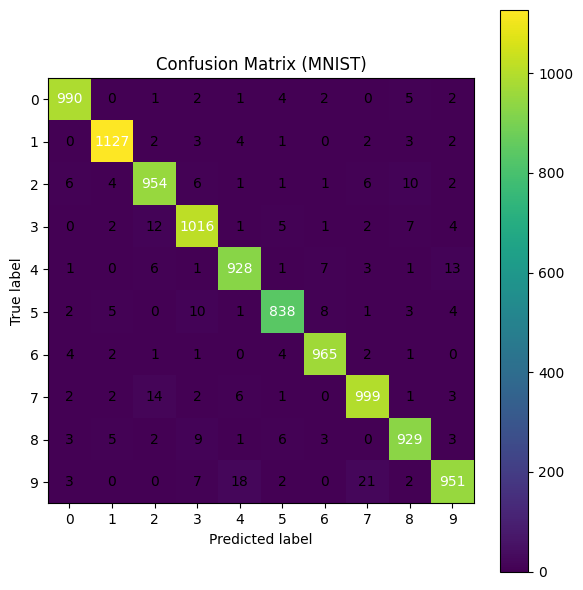

In [12]:
def confusion_matrix_np(y_true, y_pred, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_matrix_np(np.argmax(Y_test,1), y_pred_test, 10)

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
ticks = np.arange(10)
plt.xticks(ticks, ticks); plt.yticks(ticks, ticks)

th = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("reports/confusion_matrix.png", dpi=150)
plt.show()

## 11. Save artifacts (weights & biases)

In [13]:
if not USE_TWO_HIDDEN:
    np.savez("artifacts/mlp_weights_biases_1hidden.npz", W1=W1, b1=b1, W2=W2, b2=b2)
    print("Saved artifacts/mlp_weights_biases_1hidden.npz")
else:
    np.savez("artifacts/mlp_weights_biases_2hidden.npz", W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3)
    print("Saved artifacts/mlp_weights_biases_2hidden.npz")

Saved artifacts/mlp_weights_biases_1hidden.npz


## 12. Per-Class Metrics and “Most-Confident Mistakes”

              precision    recall  f1-score   support

           0     0.9792    0.9831    0.9812      1007
           1     0.9826    0.9851    0.9838      1144
           2     0.9617    0.9627    0.9622       991
           3     0.9612    0.9676    0.9644      1050
           4     0.9657    0.9657    0.9657       961
           5     0.9710    0.9610    0.9660       872
           6     0.9777    0.9847    0.9812       980
           7     0.9643    0.9699    0.9671      1030
           8     0.9657    0.9667    0.9662       961
           9     0.9665    0.9472    0.9567      1004

    accuracy                         0.9697     10000
   macro avg     0.9696    0.9694    0.9694     10000
weighted avg     0.9697    0.9697    0.9697     10000



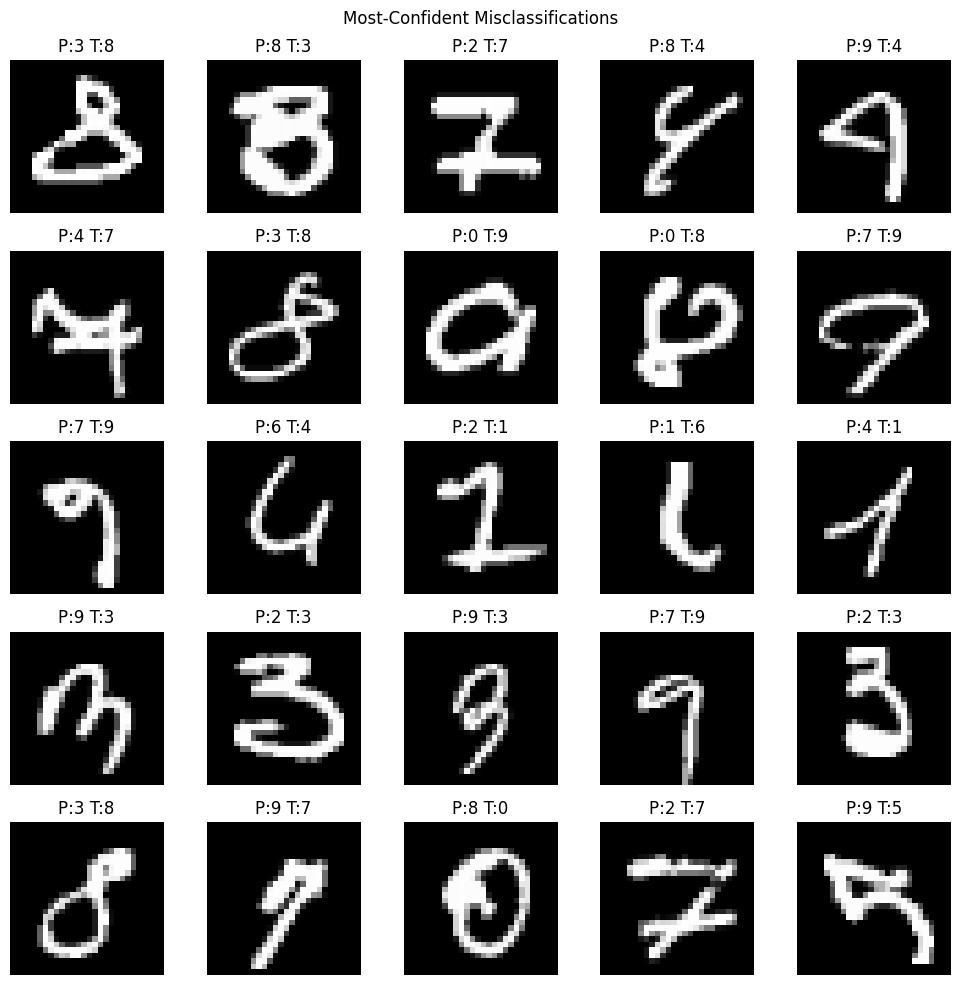

In [14]:
# Per-class metrics (precision/recall/F1)
from sklearn.metrics import classification_report

y_true = np.argmax(Y_test, 1)
print(classification_report(y_true, y_pred_test, digits=4))

# Most-confident mistakes (which wrong predictions had highest confidence?)
# uses probs_test from the evaluation block
conf = probs_test.max(axis=1)        # model confidence per sample
wrong_idx = np.where(y_pred_test != y_true)[0]
worst = wrong_idx[np.argsort(-conf[wrong_idx])][:25]  # top 25 confident errors

plt.figure(figsize=(10,10))
for k, i in enumerate(worst):
    plt.subplot(5,5,k+1)
    plt.imshow(X_test[i].reshape(28,28), cmap="gray")
    plt.title(f"P:{y_pred_test[i]} T:{y_true[i]}")
    plt.axis("off")
plt.suptitle("Most-Confident Misclassifications")
plt.tight_layout(); plt.show()

## 13. Calibration (Reliability Diagram + ECE)

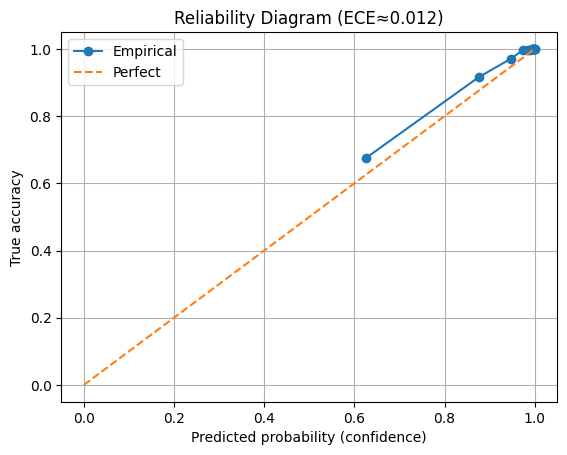

In [15]:
from sklearn.calibration import calibration_curve

# confidence of predicted class
proba = probs_test.max(axis=1)
y_true = np.argmax(Y_test, 1)

# reliability curve (empirical accuracy vs predicted probability)
prob_true, prob_pred = calibration_curve(
    (y_pred_test == y_true).astype(int), proba, n_bins=15, strategy="quantile"
)

def expected_calibration_error(y_prob, y_pred, y_true, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    idx = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        sel = (idx == b)
        if np.any(sel):
            conf = y_prob[sel].mean()
            acc  = (y_pred[sel] == y_true[sel]).mean()
            ece += np.abs(acc - conf) * sel.mean()
    return float(ece)

ece = expected_calibration_error(proba, y_pred_test, y_true)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="Empirical")
plt.plot([0,1], [0,1], "--", label="Perfect")
plt.xlabel("Predicted probability (confidence)")
plt.ylabel("True accuracy")
plt.title(f"Reliability Diagram (ECE≈{ece:.3f})")
plt.legend(); plt.grid(True); plt.show()

## 14. Saliency (Input-Gradient) Maps

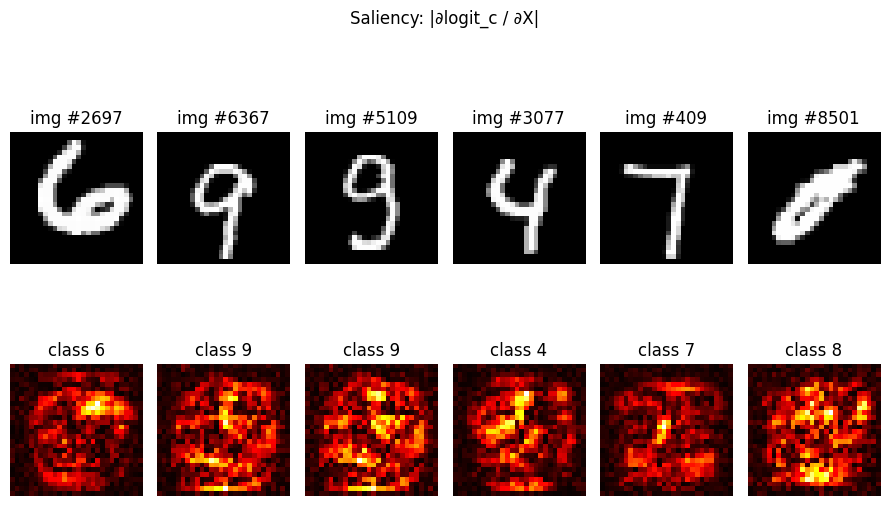

In [16]:
# We'll compute ∂logit_c / ∂X for the predicted class c

def forward_intermediates(X):
    """Return intermediate activations for saliency."""
    if not USE_TWO_HIDDEN:
        z1 = X @ W1 + b1; a1 = sigmoid(z1)
        z2 = a1 @ W2 + b2; a2 = softmax(z2)
        return z1, a1, z2, a2
    else:
        z1 = X @ W1 + b1; a1 = sigmoid(z1)
        z2 = a1 @ W2 + b2; a2 = sigmoid(z2)
        z3 = a2 @ W3 + b3; a3 = softmax(z3)
        return z1, a1, z2, a2, z3, a3

def saliency_for_sample(x_row):
    """
    Returns:
      pred_class (int), saliency_map (28x28) of |∂logit_c/∂X|
    """
    x = x_row[None, :]
    if not USE_TWO_HIDDEN:
        z1, a1, z2, a2 = forward_intermediates(x)
        c = int(np.argmax(a2, axis=1)[0])

        # gradient of logit_c wrt z2 is 1 at c, 0 elsewhere
        dlogit = np.zeros_like(z2); dlogit[0, c] = 1.0

        # backprop to input
        da1 = dlogit @ W2.T                    # (1, H1)
        dz1 = da1 * (a1 * (1 - a1))            # (1, H1)
        dX  = dz1 @ W1.T                       # (1, 784)
        return c, np.abs(dX[0]).reshape(28, 28)

    else:
        z1, a1, z2, a2, z3, a3 = forward_intermediates(x)
        c = int(np.argmax(a3, axis=1)[0])

        d3 = np.zeros_like(z3); d3[0, c] = 1.0 # ∂logit_c/∂z3
        d2 = (d3 @ W3.T) * (a2 * (1 - a2))     # chain to layer 2
        d1 = (d2 @ W2.T) * (a1 * (1 - a1))     # chain to layer 1
        dX = d1 @ W1.T
        return c, np.abs(dX[0]).reshape(28, 28)

# visualize a few random test images + their saliency
idxs = np.random.default_rng(0).choice(X_test.shape[0], size=6, replace=False)

plt.figure(figsize=(9, 6))
for j, i in enumerate(idxs):
    pred_cls, grad_img = saliency_for_sample(X_test[i])
    # original
    plt.subplot(2, 6, j + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off"); plt.title(f"img #{i}")
    # saliency
    plt.subplot(2, 6, 6 + j + 1)
    plt.imshow(grad_img, cmap="hot")
    plt.axis("off"); plt.title(f"class {pred_cls}")
plt.suptitle("Saliency: |∂logit_c / ∂X|")
plt.tight_layout(); plt.show()

## 15. Model Card and Config (JSON Artifacts)

In [17]:
import time, platform

# infer epochs used if training 'history' is available
try:
    epochs_used = len(history["loss"])
except Exception:
    epochs_used = 15  # fallback to your default if history isn't present

card = {
    "model_name": "MNIST-MLP-FromScratch",
    "version": "1.0.0",
    "created_utc": int(time.time()),
    "task": "image-classification-digit",
    "frameworks": "none (NumPy only)",
    "topology": {
        "input": 784,
        "hidden": [int(hidden_size_1)] if not USE_TWO_HIDDEN else [int(hidden_size_1), int(hidden_size_2)],
        "output": 10
    },
    "activations": {"hidden": "sigmoid", "output": "softmax"},
    "normalization": "[0.01, 1.0] range (guarded to avoid double-normalization)",
    "training": {
        "optimizer": "SGD+momentum",
        "lr_start": 0.1,
        "lr_decay_per_epoch": 0.95,
        "batch_size": 128,
        "epochs": epochs_used,
        "weight_decay_L2": 1e-4,
        "momentum": 0.9
    },
    "dataset": "MNIST CSV (course-provided format)",
    "metrics": {"test_accuracy": float(test_acc/100.0)},
    "intended_use": "Educational baseline; benchmarking; demos",
    "limitations": ["Small MLP; grayscale digits only", "No adversarial robustness"],
    "system": {"python": platform.python_version(), "numpy": np.__version__}
}
with open("reports/model_card.json", "w") as f:
    json.dump(card, f, indent=2)
print("Saved reports/model_card.json")

CONFIG = {
    "USE_TWO_HIDDEN": bool(USE_TWO_HIDDEN),
    "hidden_size_1": int(hidden_size_1),
    "hidden_size_2": int(hidden_size_2) if USE_TWO_HIDDEN else None,
    "epochs": epochs_used,
    "batch_size": 128,
    "lr0": 0.1,
    "lr_decay": 0.95,
    "momentum": 0.9,
    "weight_decay_L2": 1e-4,
    "seed": 42
}
with open("reports/config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)
print("Saved reports/config.json")

Saved reports/model_card.json
Saved reports/config.json


## 16. Minimal Predict Helpers (API-Style)

In [18]:
def predict_proba(X):
    """Return class probabilities for inputs X using the current weights."""
    if not USE_TWO_HIDDEN:
        probs, _ = forward_one_hidden(X)
    else:
        probs, _ = forward_two_hidden(X)
    return probs

def predict_label(X):
    """Return predicted digit labels for inputs X."""
    return np.argmax(predict_proba(X), axis=1)

# quick sanity check on first 5 test samples
print("Predictions for first 5 test images:", predict_label(X_test[:5]).tolist())

Predictions for first 5 test images: [9, 0, 0, 9, 1]


In [20]:
# This cell re-initializes a wider 1-hidden-layer network and retrains it.
# It uses the SAME pipeline, just wider and trained a bit longer.

USE_TWO_HIDDEN = False
hidden_size_1 = 256   # wider than 128

# re-init weights for the new width
def xavier_init(fan_in, fan_out, rng=RNG):
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return rng.uniform(-limit, limit, size=(fan_in, fan_out)).astype(np.float32)

W1 = xavier_init(input_size,  hidden_size_1); b1 = np.zeros((1, hidden_size_1), dtype=np.float32)
W2 = xavier_init(hidden_size_1, output_size); b2 = np.zeros((1, output_size),    dtype=np.float32)
W3, b3 = None, None  # keep names defined

# train a bit longer with slightly stronger momentum
history = train(
    X_trn, Y_trn, X_val, Y_val,
    epochs=25, batch_size=128,
    lr0=0.1, momentum=0.95, lam=1e-4,
    lr_decay=0.95, early_stop=True, patience=5
)

# evaluate again
probs_test, y_pred_test, test_acc = evaluate(X_test, Y_test)

# optional: quick results snapshot
y_true = np.argmax(Y_test, 1)
correct = int((y_pred_test == y_true).sum())
incorrect = int(Y_test.shape[0] - correct)
print("\n### Updated Results Snapshot")
print(f"- **Hidden layer(s):** 1 × {hidden_size_1} logistic")
print(f"- **Accuracy (test)** = {test_acc:.2f}%")
print(f"- **Correct classifications**: {correct}")
print(f"- **Incorrect classifications**: {incorrect}")

Epoch 01/25 | loss 0.2527 | acc 93.73% | val_loss 0.2500 | val_acc 93.32% | lr 0.1000
Epoch 02/25 | loss 0.1955 | acc 95.67% | val_loss 0.1983 | val_acc 95.18% | lr 0.0950
Epoch 03/25 | loss 0.1638 | acc 96.85% | val_loss 0.1745 | val_acc 96.35% | lr 0.0902
Epoch 04/25 | loss 0.1558 | acc 97.13% | val_loss 0.1695 | val_acc 96.50% | lr 0.0857
Epoch 05/25 | loss 0.1400 | acc 97.73% | val_loss 0.1563 | val_acc 96.83% | lr 0.0815
Epoch 06/25 | loss 0.1336 | acc 98.01% | val_loss 0.1517 | val_acc 97.25% | lr 0.0774
Epoch 07/25 | loss 0.1312 | acc 98.06% | val_loss 0.1523 | val_acc 97.27% | lr 0.0735
Epoch 08/25 | loss 0.1258 | acc 98.34% | val_loss 0.1470 | val_acc 97.48% | lr 0.0698
Epoch 09/25 | loss 0.1218 | acc 98.46% | val_loss 0.1438 | val_acc 97.32% | lr 0.0663
Epoch 10/25 | loss 0.1180 | acc 98.65% | val_loss 0.1419 | val_acc 97.60% | lr 0.0630
Epoch 11/25 | loss 0.1170 | acc 98.67% | val_loss 0.1412 | val_acc 97.58% | lr 0.0599
Epoch 12/25 | loss 0.1144 | acc 98.78% | val_loss 0.14